In [3]:
!pip install AugmentedSocialScientist pandas numpy wordcloud matplotlib spacy nltk
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 11.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# Description des annotations

## Description des catégories en nombre et recodage

In [4]:
import pandas as pd
simplify_labels = False
take_sentence_with_context = True

if(take_sentence_with_context):
    text_var = "sentence_text"
else:
    text_var = "sentence"

current_annotations_file = "../data/intermediate/annotations/personne_1400annotations_2024-03-27_ActiveTigger.csv"

annotations_file = pd.read_csv(current_annotations_file)
# defining the label variable, with a possible recategorization before training
label_categories = {
    "Poubelle" : "Anything but personne à protéger",
    "Humain comme empathie" : "Anything but personne à protéger",
    "Sentiment humain": "Anything but personne à protéger",
    "Genre/espèce humaine": "Anything but personne à protéger",
    "Matériel biologique": "Anything but personne à protéger",
    "Individu": "Anything but personne à protéger",
    "Individu ou sujet" : "Anything but personne à protéger",
    "Agent responsable":"Anything but personne à protéger",
    "Personne responsable et autonome" : "Anything but personne à protéger",
    "Personne relationnelle": "Anything but personne à protéger",
    "Personne à protéger":"Personne à protéger"
}

if(simplify_labels):
    annotations_file['label'] = annotations_file['Personne'].map(label_categories)
else:
    annotations_file['label'] = annotations_file['Personne']

# defining text variable    
annotations_file['text'] = annotations_file[text_var]


annotations_file.sample(5)

sentence_id                          Personne  \
1196       610081                               NaN   
854       1250174              Genre/espèce humaine   
1463      1030086  Personne responsable et autonome   
178       1270179               Personne à protéger   
8          580057               Personne à protéger   

                                          sentence_text  \
1196  Il est très difficile de prédire\nquelles sero...   
854   La mise \nen place de la Convention sur la div...   
1463  Ces souve nirs pénibles ont laissé des traces ...   
178   Une série d’articles portant sur la santé et l...   
8     F. Lemaire (Hôpital Henri Mondor, Créteil),\nR...   

                                 label  \
1196                               NaN   
854               Genre/espèce humaine   
1463  Personne responsable et autonome   
178                Personne à protéger   
8                  Personne à protéger   

                                                   text  
1196  Il est très difficile de prédire\nquelles sero...  
854   La mise \nen place de la Convention sur la div...  
1463  Ces souve nirs pénibles ont laissé des traces ...  
178   Une série d’articles portant sur la santé et l...  
8     F. Lemaire (Hôpital Henri Mondor, Créteil),\nR...

In [5]:
# filtering out not annotated (na) and some categories
annotations = annotations_file.dropna()
annotations = annotations[~annotations["Personne"].isin(["Poubelle"])]
annotations.sample(5)

sentence_id                Personne  \
972       1291028       Individu ou sujet   
584        940383       Individu ou sujet   
947       1060295     Personne à protéger   
342        870470  Personne relationnelle   
1666       610110    Genre/espèce humaine   

                                          sentence_text  \
972   Enfin, \nl’utilisation  de techniques biomédic...   
584   - Difficile le weekend, et même  le jour en se...   
947   La pandémie grippale ne fera pas disparaître l...   
342   30 familial, amical, légal ? Quels intérêts co...   
1666  Un foie cancéreux qui tue progressivement un h...   

                       label  \
972        Individu ou sujet   
584        Individu ou sujet   
947      Personne à protéger   
342   Personne relationnelle   
1666    Genre/espèce humaine   

                                                   text  
972   Enfin, \nl’utilisation  de techniques biomédic...  
584   - Difficile le weekend, et même  le jour en se...  
947   La pandémie grippale ne fera pas disparaître l...  
342   30 familial, amical, légal ? Quels intérêts co...  
1666  Un foie cancéreux qui tue progressivement un h...

In [6]:
annotations["Personne"].value_counts()

Personne
Individu ou sujet                   232
Personne à protéger                 230
Corps humain                        229
Personne relationnelle              222
Personne responsable et autonome    220
Genre/espèce humaine                214
Sentiment humain                     35
Name: count, dtype: int64

In [7]:
annotations["label"].value_counts()

label
Individu ou sujet                   232
Personne à protéger                 230
Corps humain                        229
Personne relationnelle              222
Personne responsable et autonome    220
Genre/espèce humaine                214
Sentiment humain                     35
Name: count, dtype: int64

## Description lexicographique

In [8]:
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the French language model from spaCy
nlp = spacy.load("fr_core_news_sm")

# Function to lemmatize text
def lemmatize_text(text):
    custom_stop_words = ["e"]
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token in custom_stop_words])
    return lemmatized

# Apply lemmatization to the 'text' column
annotations['lemmatized_text'] = annotations['text'].apply(lemmatize_text)

In [9]:
import re
def filter_words(text):

    # Compile regex pattern with word boundaries
    pattern = re.compile(r'\b(?:' + '|'.join(words_to_filter) + r')\b', flags=re.IGNORECASE)
    return pattern.sub('', text)

In [10]:
words_to_filter = ['l','e','ceue']

annotations["lemmatized_text"]=annotations["lemmatized_text"].apply(filter_words)

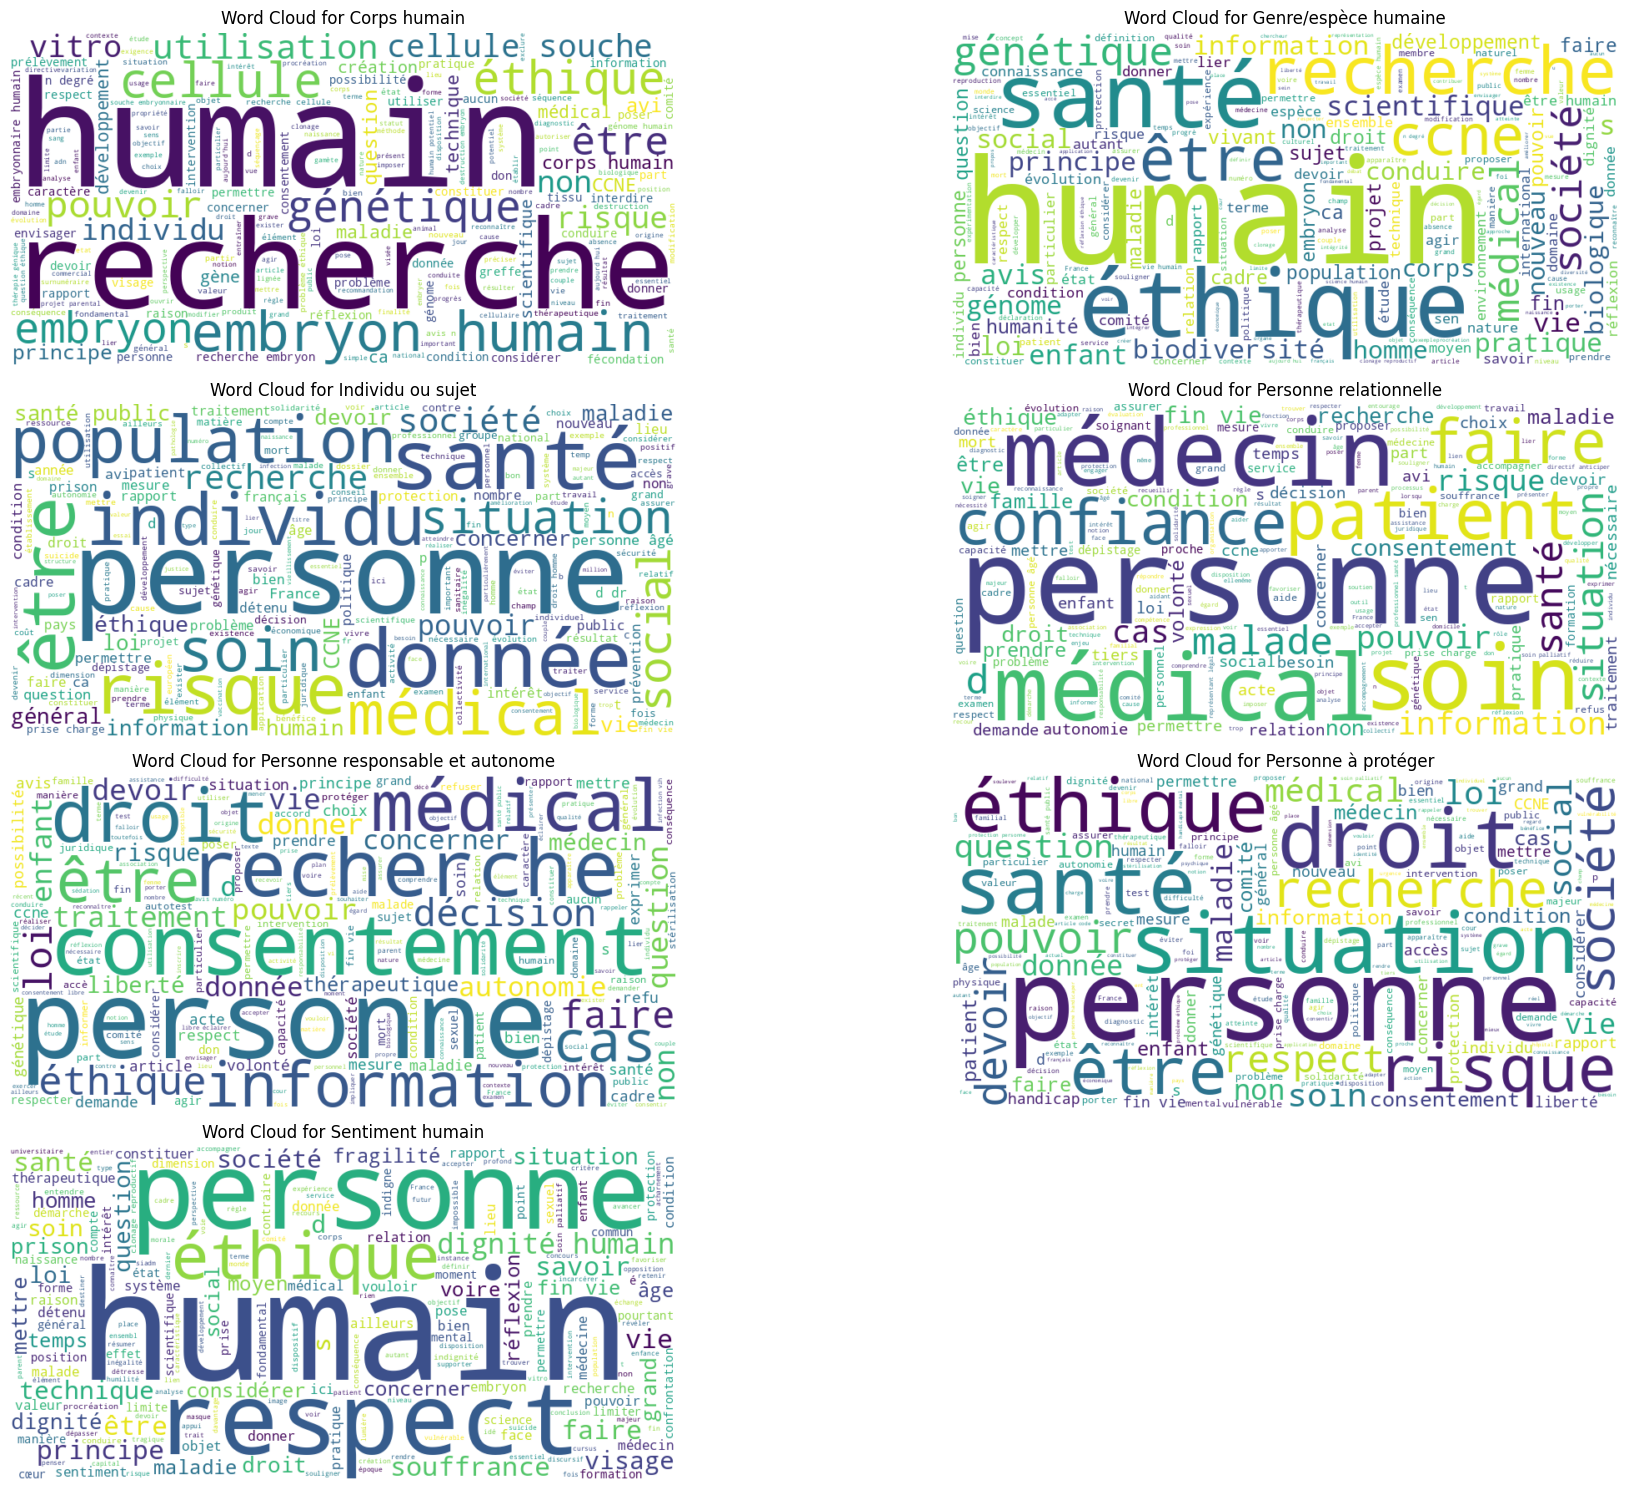

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Determine the number of categories
num_categories = annotations['Personne'].nunique()

# Setup plot grid (2 columns, 3 rows max)
cols = 2
rows = round(num_categories/cols)
# Create the figure with a gridspec
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(rows, cols, figure=fig)

# Counter for subplot index
subplot_index = 0

for category, group in annotations.groupby('Personne'):
    combined_text = " ".join(group['lemmatized_text'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)
    
    # Calculate row, col index for the current subplot
    row = subplot_index // cols
    col = subplot_index % cols
    
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {category}')
    ax.axis('off')
    
    subplot_index += 1

plt.tight_layout()
plt.show()

In [12]:
words_to_filter = ['recherche','humain','médical','médecin','personne','soin','éthique','santé','droit','l','e','ceue']

annotations["lemmatized_text_without_big_words"]=annotations["lemmatized_text"].apply(filter_words)


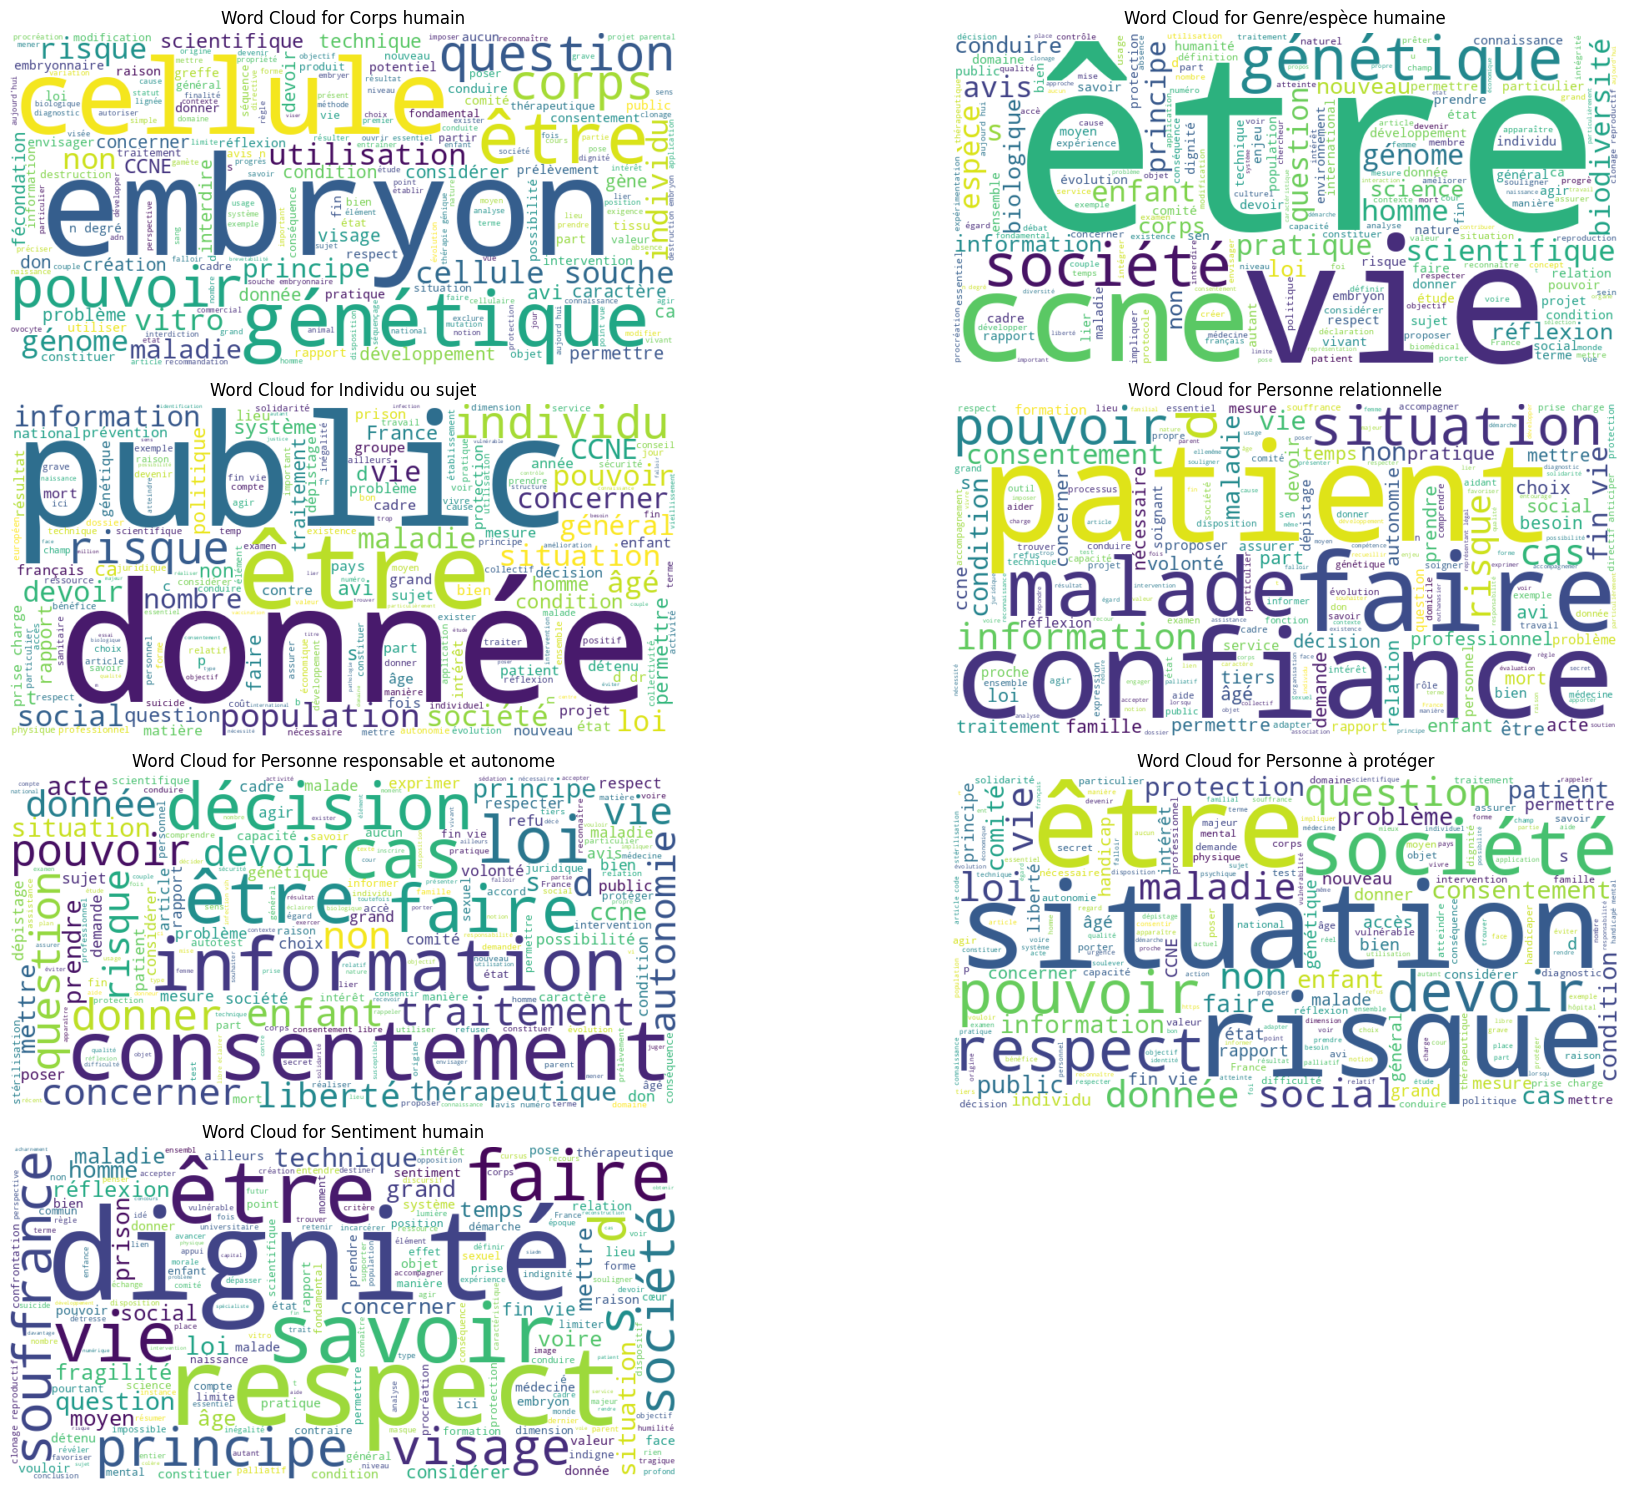

In [13]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Determine the number of categories
num_categories = annotations['Personne'].nunique()

# Setup plot grid (2 columns, 3 rows max)
cols = 2
rows = round(num_categories/cols)
# Create the figure with a gridspec
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(rows, cols, figure=fig)

# Counter for subplot index
subplot_index = 0

for category, group in annotations.groupby('Personne'):
    combined_text = " ".join(group['lemmatized_text_without_big_words'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(combined_text)
    
    # Calculate row, col index for the current subplot
    row = subplot_index // cols
    col = subplot_index % cols
    
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {category}')
    ax.axis('off')
    
    subplot_index += 1

plt.tight_layout()
plt.show()

# Bert classification

In [14]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from torch import cuda

cuda.get_device_name(0)

'Tesla T4'

In [15]:
from sklearn.model_selection import train_test_split
 
train_data, test_data = train_test_split(annotations, train_size=0.80)

In [16]:
from AugmentedSocialScientist.models import Camembert

bert = Camembert()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


There are 1 GPU(s) available.
We will use GPU 0: Tesla T4


In [17]:
batch_size = 16
train_loader = bert.encode(train_data.text.values,
train_data.label.values, batch_size=batch_size)

  0%|          | 0/1105 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1022 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1105 [00:00<?, ?it/s]

label ids: {'Corps humain': 0, 'Genre/espèce humaine': 1, 'Individu ou sujet': 2, 'Personne relationnelle': 3, 'Personne responsable et autonome': 4, 'Personne à protéger': 5, 'Sentiment humain': 6}


In [18]:
test_loader = bert.encode(test_data.text.values,
test_data.label.values, batch_size=batch_size)

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

label ids: {'Corps humain': 0, 'Genre/espèce humaine': 1, 'Individu ou sujet': 2, 'Personne relationnelle': 3, 'Personne responsable et autonome': 4, 'Personne à protéger': 5, 'Sentiment humain': 6}


In [19]:
scores = bert.run_training(
    train_loader,
    test_loader,
    n_epochs=3,
    lr=2e-5,
    random_state=42,
    save_model_as='clickbait'
    )

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/mamba/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...
  Batch    40  of     70.    Elapsed: 0:00:54.

  Average training loss: 1.88
  Training took: 0:01:35

Running Validation...

  Average test loss: 1.77
  Validation took: 0:00:08
                                  precision    recall  f1-score   support

                    Corps humain       0.45      0.79      0.57        39
            Genre/espèce humaine       0.75      0.13      0.23        45
               Individu ou sujet       0.64      0.30      0.41        53
          Personne relationnelle       0.31      0.72      0.44        39
Personne responsable et autonome       0.32      0.55      0.41        42
             Personne à protéger       0.40      0.11      0.17        54
                Sentiment humain       0.00      0.00      0.00         5

                        accuracy                           0.40       277
                       macro avg       0.41      0.37      0.32       277
                    weighted avg   

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

  Batch    40  of     70.    Elapsed: 0:00:59.

  Average training loss: 1.69
  Training took: 0:01:43

Running Validation...

  Average test loss: 1.60
  Validation took: 0:00:08
                                  precision    recall  f1-score   support

                    Corps humain       0.45      0.87      0.60        39
            Genre/espèce humaine       0.78      0.40      0.53        45
               Individu ou sujet       0.69      0.45      0.55        53
          Personne relationnelle       0.33      0.87      0.48        39
Personne responsable et autonome       0.45      0.40      0.42        42
             Personne à protéger       0.33      0.02      0.04        54
                Sentiment humain       0.00      0.00      0.00         5

                        accuracy                           0.46       277
                       macro avg       0.43      0.43      0.37       277
                    weighted avg       0.50      0.46      0.41       277


==

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

  Batch    40  of     70.    Elapsed: 0:01:01.

  Average training loss: 1.57
  Training took: 0:01:45

Running Validation...

  Average test loss: 1.56
  Validation took: 0:00:08
                                  precision    recall  f1-score   support

                    Corps humain       0.49      0.82      0.62        39
            Genre/espèce humaine       0.75      0.47      0.58        45
               Individu ou sujet       0.68      0.47      0.56        53
          Personne relationnelle       0.30      0.87      0.44        39
Personne responsable et autonome       0.38      0.26      0.31        42
             Personne à protéger       0.25      0.02      0.03        54
                Sentiment humain       0.00      0.00      0.00         5

                        accuracy                           0.45       277
                       macro avg       0.41      0.42      0.36       277
                    weighted avg       0.47      0.45      0.40       277


Tr

/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.11/site-packages/sklearn/m

In [20]:
import numpy as np
pred_data = annotations_file[annotations_file["label"].isna()][["text"]].dropna()
pred_loader = bert.encode(pred_data.text.values, batch_size=batch_size)
pred_proba = bert.predict_with_model(pred_loader, model_path='./models/clickbait')
pred_data['pred_label'] = np.argmax(pred_proba, axis=1)
pred_data['pred_proba'] = np.max(pred_proba, axis=1)

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

label ids: {'Corps humain': 0, 'Genre/espèce humaine': 1, 'Individu ou sujet': 2, 'Personne relationnelle': 3, 'Personne responsable et autonome': 4, 'Personne à protéger': 5, 'Sentiment humain': 6}


In [21]:
pred_data["pred_proba"].describe()

count    598.000000
mean       0.265045
std        0.062830
min        0.174725
25%        0.220936
50%        0.241333
75%        0.293150
max        0.397288
Name: pred_proba, dtype: float64

In [22]:
pd.set_option('display.max_colwidth', None)  # Use None to show all the text, or set a large number

pred_data

text  \
1138             Et à l’importance nouvelle que prenait le projet parental répondait l’émergence d’une forme  \nnouvelle de responsabilité médicale et sociale quant au devenir de cet embryon avant son  \ntransfert dans le corps de la mère. C’est dans ce contexte radicalement nouveau de début de la vie humaine qu’est apparue la  \nquestion nouvelle du devenir de ces embryons in vitro lorsqu’ils n’étaient pas transférés dans  \nle corps de leur mère. Il  y  a  aujourd’hui  au  moins  trois  circonstances  qui  vont  conduire  à  une  décision \nmédicale d’absence de transfert  d’un embryon créé  in vitro  par AMP dans le cadre d’un  \nprojet parental :\n1. lorsqu’une anomalie majeure ou une interruption du développement d’un embryon est  \nmanifeste in vitro, avant son transfert dans le corps de sa mère  ;\n2. lorsqu’au cours d’un diagnostic préimplantatoire (DPI), un embryon se révèle être porteur  \nde la séquence génétique en cause dans une maladie familiale d’une particulière gravité et  \n4\nincurable  au  moment  du  diagnostic,  séquence  génétique  dont  la  recherche  a  motivé  la  \nréalisation du DPI 1.   
1139                                                                                                                                                                                                                                      9\ndemande d’un enfant devenu majeur le rapprochement des parties concernées et à \nrésoudre des dilemmes dans des situations difficiles. Avant d’éviter toute ambiguïté, le \nnouvel article L 1477 du Code de l’action sociale et des familles précise que l’accès d’une \npersonne à ses origines est sans effet sur l’état civil et la filiation, « il ne fait naître ni \ndroit ni obligation au profit ou à la charge de qui que ce soit ». La Cour  europé enne des droits de l’hom me a rejeté le 13 février 2003  à Strasbourg,  la requête \nd’une  personne  de 37 ans, abandonné e avec demande de secret et adoptée par la suite, qui \nalléguait que le secret de sa naissance et l’impossibilité qui en résultait pour elle de conna ître \nses origines constituaient une violation de ses droits garantis par l’article 8 de la Conve ntion \net une discrimination contraire à l’article 14 de la Conve ntion.   
1141                                                                                                                                                                                                                                                                                                                                                                          2.1. Mutations du concept de santé : progrès et nouvelles \nfragilités \n \n(i) Les maladies chroniques, un nouveau paradigme pour notre système de \nsanté \n \nLes maladies dites « chroniques », sont fréquentes - elles affectent en France \nenviron 15 millions de personnes, soit 20 % de la population, dont 9 millions sont \ndéclarées en affections de longue durée (ALD). Le nombre de maladies \nchroniques et de patients atteints est en augmentation constante, conséquence de \nl’allongement de la durée de vie, de l’efficacité des traitements (VIH, cancers , \nmaladies cardiovasculaires), mais aussi de multiples facteurs environnementaux \n« pathogènes », regroupés sous la notion nouvelle « d’exposome  » qui souligne le \nlien entre santé et environnement.   
1142                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Le droit de savoir\nIl faut tenir cha